#### Teichman datasets (Litvinkova et al. 2020, Kanemaru et al. 2023)

Downloaded the raw counts from Heart Atlas v2

1. Technology: there are 3 technologies: 10x Multiome-v1 (Kanemaru), 10x Nuclei_3prime-v2 (Litvinukova), 10x Nuclei_3prime-v3 (Litvinukova)
2. Cell vs. nuclei: Both, but we will filter to just the nuclei
3. Regions: whole heart ('LV': 148429, 'RV': 104454, 'AX': 102221, 'SP': 99024, 'LA': 74501, 'SAN': 69153, 'RA': 57495, 'AVN': 49019), but we will filter to just LV; AX = apex, SP = interventricular septum

#### This script cleans up the metadata and makes it more consistent with other datasets 

After this script, run the separate preprocessing steps for each of the different technologies.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [2]:
def age_convertor(input_string):
    '''
    Convert the age group to the midway value (e.g., 70-75 = 72.5)
    '''
    
    # Split the input string by '-'
    parts = input_string.split('-')

    # Convert parts to integers
    numbers = [int(part) for part in parts]

    # Calculate the average
    average_value = sum(numbers) / len(numbers)

    return average_value

In [3]:
def confirm_raw_counts(adata):
    """
    Check if every value in adata.X.sum(axis=1), the sum of counts across all genes per cell, is an integer.   

    Parameters:
    adata (AnnData): The AnnData object containing the data matrix (adata.X).

    Returns:
    bool: True if all sums are integers, False otherwise.
    """
    # Sum across rows (axis=1), which correspond to the genes
    sums = adata.X.sum(axis=1)
    
    # Check if all sums are integers by comparing them to their rounded versions
    return np.all(np.equal(sums, np.round(sums)))

In [4]:
%%time
# read in the entire dataset
adata = sc.read_h5ad("Global_raw_RNA_counts.h5ad")

CPU times: user 1.63 s, sys: 5.09 s, total: 6.72 s
Wall time: 6.72 s


In [5]:
# confirm that these are the raw counts
confirm_raw_counts(adata)

True

In [6]:
# the sinoatrial node region has 'nan' for age
# but these correspond to donors AH1 and A61, which per the metadata has age 45-50 and 70-75, respectively
adata.obs.loc[adata.obs.age == 'nan', ]
adata.obs.loc[adata.obs.donor == "AH1", 'age'] = '45-50'
adata.obs.loc[adata.obs.donor == "A61", 'age'] = '70-75'
adata.obs.age = adata.obs.age.cat.remove_unused_categories()

In [7]:
# extract the relevant metadata
metadata = adata.obs[['donor', 'age', 'gender', 'scANVI_predictions', 'batch', 'region']]

# for later consistency, change the column names
metadata = metadata.rename(
    columns={'scANVI_predictions': 'cell_type', 
             'gender': 'sex', 
             'donor': 'donor_id', 
             'batch': 'technology'})

# convert age to numerical value
metadata.age = metadata.age.apply(lambda x: age_convertor(x))

# add technology
metadata.technology = metadata.technology.apply(lambda x: x.split('_', 1)[-1])

# since some donors have runs on 10X GEX and Multiome, concatenate these as the donor_id
metadata['donor_id'] = metadata['donor_id'].astype('str')
metadata['technology'] = metadata['technology'].astype('str')
metadata['donor_id'] = metadata['donor_id'] + "-" + metadata['technology']

# add additional columns to metadata
metadata['study'] = 'Teichman'
metadata['sex'] = metadata['sex'].str.lower() # make sex lowercase 

# extract the sample type (cell or nuclei) from the technology column
split_data = metadata['technology'].str.split('_', n=1, expand=True)

metadata['cell_or_nuclei'] = split_data[0]
metadata['technology'] = split_data[1]

# add back metadata to adata
adata.obs = metadata
adata.obs.head()

,donor_id,age,sex,cell_type,technology,region,study,cell_or_nuclei
barcode,,,,,,,,
HCAHeart7606896_GATGAGGCACGGCTAC,D1-Cell_3prime-v2,52.5,female,Endothelial cell,3prime-v2,AX,Teichman,Cell
HCAHeart7606896_CGCTTCACATTTGCCC,D1-Cell_3prime-v2,52.5,female,Mural cell,3prime-v2,AX,Teichman,Cell
HCAHeart7606896_GTTAAGCAGAGACTAT,D1-Cell_3prime-v2,52.5,female,Endothelial cell,3prime-v2,AX,Teichman,Cell
HCAHeart7606896_TCGCGTTGTAAGAGGA,D1-Cell_3prime-v2,52.5,female,Mural cell,3prime-v2,AX,Teichman,Cell
HCAHeart7606896_GCTGCGAGTGTTGGGA,D1-Cell_3prime-v2,52.5,female,Endothelial cell,3prime-v2,AX,Teichman,Cell


In [8]:
Counter(adata.obs.region)

Counter({'LV': 148429,
         'RV': 104454,
         'AX': 102221,
         'SP': 99024,
         'LA': 74501,
         'SAN': 69153,
         'RA': 57495,
         'AVN': 49019})

### Filter to just LV

In [9]:
adata = adata[adata.obs.region == "LV"]

In [10]:
Counter(adata.obs.region)

Counter({'LV': 148429})

### Filter to just nuclei

In [ ]:
adata = adata[adata.obs.cell_or_nuclei == "Nuclei"]

In [ ]:
Counter(adata.obs.cell_or_nuclei)

### Make the gene symbol the adata.var rather than the ENSEMBL ID

In [11]:
adata.var['ensembl_id'] = adata.var.index
adata.var.index = adata.var['gene_name-new'].astype(str)
adata.var = adata.var.drop(columns = ['gene_name-new'])
adata.var_names_make_unique()
adata.var_names = adata.var.index.astype(str)

/mnt/data1/william/tmp/ipykernel_3623605/3557197988.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


#### Create a new adata.obs column called consistent_cell_type based on the original studies' annotation

In [12]:
Counter(adata.obs.cell_type)

Counter({'Ventricular Cardiomyocyte': 65668,
         'Mural cell': 26945,
         'Endothelial cell': 25651,
         'Fibroblast': 18768,
         'Myeloid': 6553,
         'Lymphoid': 3117,
         'Neuronal cell': 899,
         'Mast cell': 444,
         'Adipocyte': 214,
         'Lymphatic Endothelial cell': 122,
         'Mesothelial cell': 29,
         'Atrial Cardiomyocyte': 19})

In [13]:
# add a consistent cell type label 
adata.obs["consistent_cell_type"] = adata.obs['cell_type'].map(
    {
        "Ventricular Cardiomyocyte": "Cardiomyocyte",
        "Atrial Cardiomyocyte": "Cardiomyocyte",
        "Endothelial cell": "Endothelial", 
        "Mural cell": "Pericyte", 
        "Lymphoid": "Lymphoid",
        "Adipocyte": "Adipocyte",
        "Fibroblast": "Fibroblast",
        "Myeloid": "Myeloid",
        "Neuronal cell": "Neuronal", 
        "Mast cell": "Mast", 
        "Lymphatic Endothelial cell": "LEC", 
        "Mesothelial cell": "Epicardial", 
    }
)

# view the unique labels
Counter(adata.obs.consistent_cell_type)

Counter({'Cardiomyocyte': 65687,
         'Pericyte': 26945,
         'Endothelial': 25651,
         'Fibroblast': 18768,
         'Myeloid': 6553,
         'Lymphoid': 3117,
         'Neuronal': 899,
         'Mast': 444,
         'Adipocyte': 214,
         'LEC': 122,
         'Epicardial': 29})

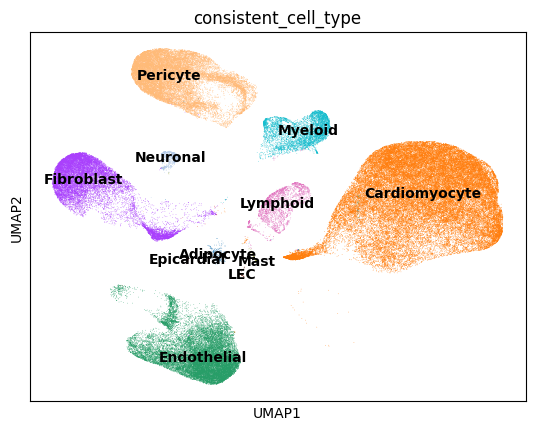

In [14]:
sc.pl.umap(adata, color = "consistent_cell_type", legend_loc = "on data")

In [ ]:
adata

In [15]:
adata.write("Teichman_LV_nuclei.h5ad")